In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Sample COVID-19 data creation (replace with your actual dataset)
def create_sample_covid_data():
    """Create sample COVID-19 data for demonstration"""
    np.random.seed(42)
    
    countries = ['USA', 'Brazil', 'India', 'Russia', 'France', 'UK', 'Turkey', 
                'Iran', 'Germany', 'Italy', 'Spain', 'Poland', 'Ukraine', 'South Africa']
    
    # Generate date range
    start_date = datetime(2020, 3, 1)
    end_date = datetime(2022, 12, 31)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    data = []
    for country in countries:
        base_cases = np.random.randint(1000, 10000)
        base_deaths = base_cases * np.random.uniform(0.01, 0.05)
        
        for i, date in enumerate(dates):
            # Simulate waves of COVID-19
            wave_factor = (np.sin(i/50) + 1) * np.random.uniform(0.5, 2.0)
            daily_cases = int(base_cases * wave_factor * np.random.uniform(0.1, 3.0))
            daily_deaths = int(base_deaths * wave_factor * np.random.uniform(0.1, 2.0))
            
            data.append({
                'date': date,
                'country': country,
                'daily_cases': max(0, daily_cases),
                'daily_deaths': max(0, daily_deaths),
                'cumulative_cases': None,  # Will calculate later
                'cumulative_deaths': None  # Will calculate later
            })
    
    df = pd.DataFrame(data)
    
    # Calculate cumulative cases and deaths
    df = df.sort_values(['country', 'date'])
    df['cumulative_cases'] = df.groupby('country')['daily_cases'].cumsum()
    df['cumulative_deaths'] = df.groupby('country')['daily_deaths'].cumsum()
    
    return df

In [4]:
# Load or create the dataset
covid_df = create_sample_covid_data() 
covid_df.head()

,date,country,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths
1036,2020-03-01,Brazil,9625,43,9625,43
1037,2020-03-02,Brazil,11072,223,20697,266
1038,2020-03-03,Brazil,2281,50,22978,316
1039,2020-03-04,Brazil,4036,38,27014,354
1040,2020-03-05,Brazil,14671,293,41685,647


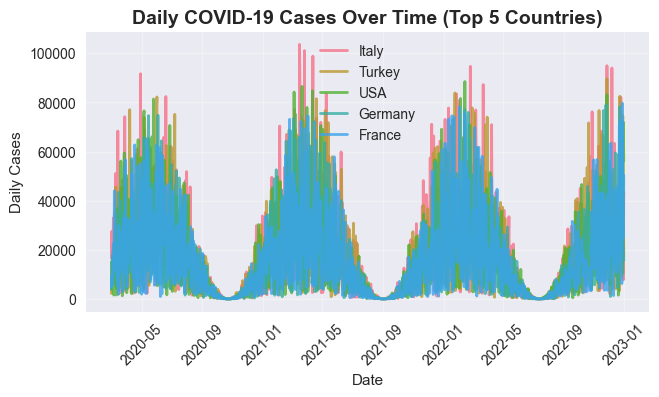

In [11]:
# 1. Time Series Plot - Daily Cases Over Time
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)

# Plot for top 5 countries by total cases
top_countries = covid_df.groupby('country')['cumulative_cases'].max().nlargest(5).index
for country in top_countries:
    country_data = covid_df[covid_df['country'] == country]
    plt.plot(country_data['date'], country_data['daily_cases'], 
             label=country, linewidth=2, alpha=0.8)

plt.title('Daily COVID-19 Cases Over Time (Top 5 Countries)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

Text(847.0858585858584, 0.5, 'Country')

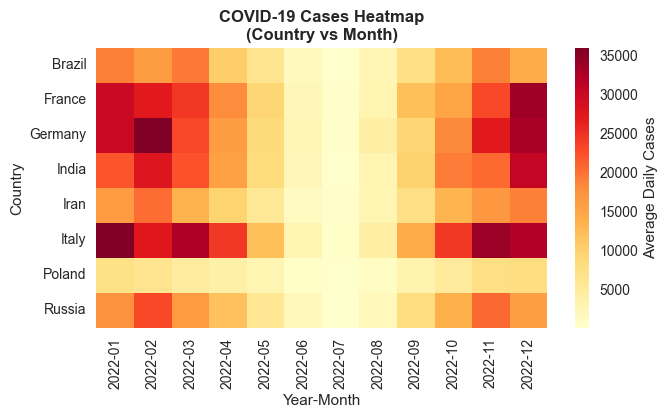

In [10]:
# 2. Heatmap - Cases by Country and Month
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 2)
covid_df['year_month'] = covid_df['date'].dt.to_period('M')
heatmap_data = covid_df.groupby(['country', 'year_month'])['daily_cases'].mean().unstack(fill_value=0)

# Select subset for better visualization
heatmap_subset = heatmap_data.iloc[:8, -12:]  # Last 12 months, top 8 countries
sns.heatmap(heatmap_subset, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Average Daily Cases'})
plt.title('COVID-19 Cases Heatmap\n(Country vs Month)', fontsize=12, fontweight='bold')
plt.xlabel('Year-Month')
plt.ylabel('Country')

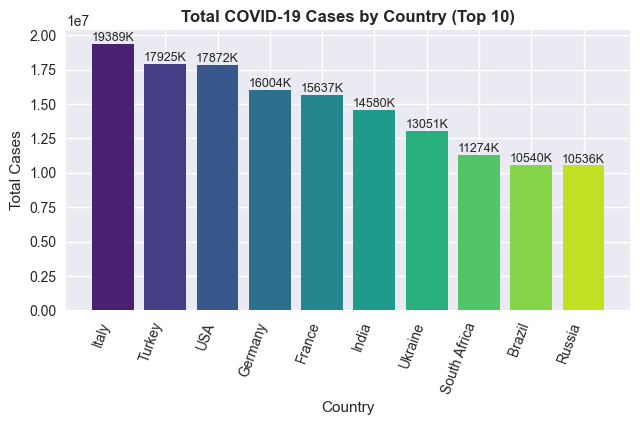

In [9]:
# 3. Bar Plot - Total Cases by Country
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 3)
total_cases = covid_df.groupby('country')['cumulative_cases'].max().sort_values(ascending=False)
top_10_cases = total_cases.head(10)

bars = plt.bar(range(len(top_10_cases)), top_10_cases.values, 
               color=sns.color_palette("viridis", len(top_10_cases)))
plt.title('Total COVID-19 Cases by Country (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(range(len(top_10_cases)), top_10_cases.index, rotation=70, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height/1000)}K', ha='center', va='bottom', fontsize=9)

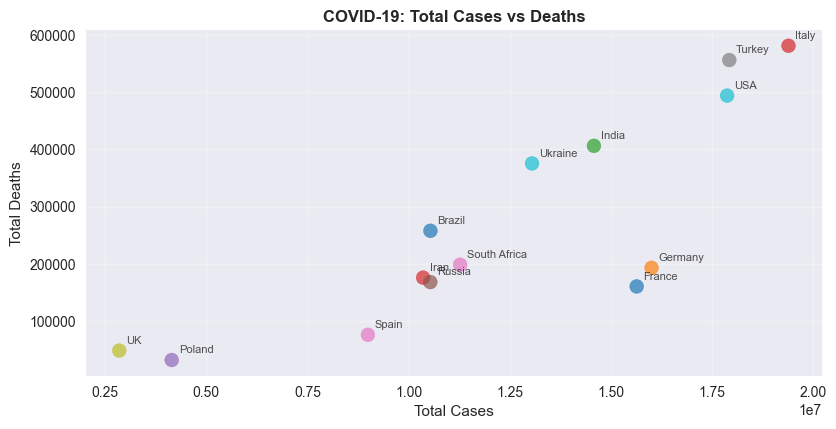

In [12]:
# 4. Scatter Plot - Cases vs Deaths
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 4)
latest_data = covid_df.groupby('country').tail(1)  # Get latest data for each country
plt.scatter(latest_data['cumulative_cases'], latest_data['cumulative_deaths'], 
           s=100, alpha=0.7, c=range(len(latest_data)), cmap='tab10')

# Add country labels
for idx, row in latest_data.iterrows():
    plt.annotate(row['country'], (row['cumulative_cases'], row['cumulative_deaths']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.title('COVID-19: Total Cases vs Deaths', fontsize=12, fontweight='bold')
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Daily Cases')

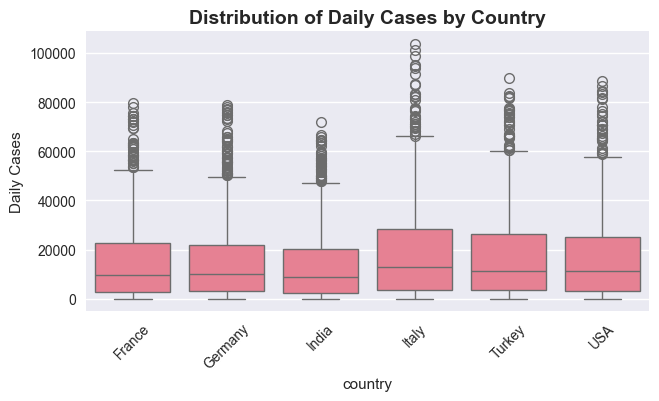

In [14]:
# Additional Seaborn-specific plots
#fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5. Box Plot - Distribution of Daily Cases by Country
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
top_6_countries = covid_df.groupby('country')['cumulative_cases'].max().nlargest(6).index
subset_df = covid_df[covid_df['country'].isin(top_6_countries)]
sns.boxplot(data=subset_df, x='country', y='daily_cases', ax=plt.gca())
plt.title('Distribution of Daily Cases by Country', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Daily Cases')

Text(0, 0.5, 'Daily Deaths')

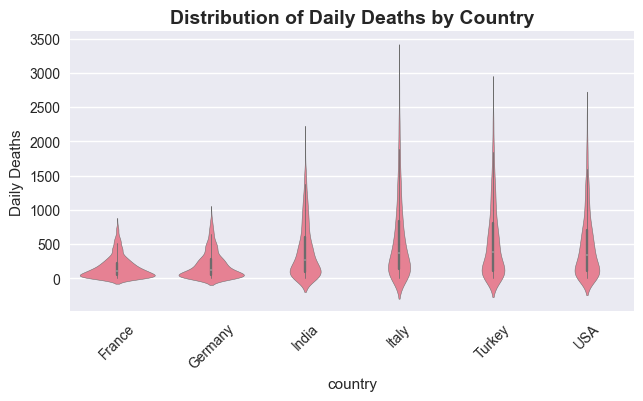

In [15]:
# 6. Violin Plot - Daily Deaths Distribution
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 2)
sns.violinplot(data=subset_df[subset_df['daily_deaths'] > 0], 
               x='country', y='daily_deaths', ax=plt.gca())
plt.title('Distribution of Daily Deaths by Country', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Daily Deaths')

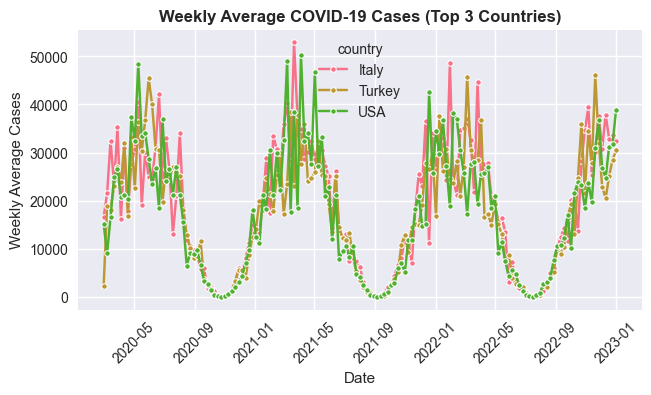

In [17]:
# 7. Line Plot with Confidence Intervals
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 3)
# Resample data to weekly averages for smoother visualization
weekly_data = covid_df.set_index('date').groupby('country').resample('W')['daily_cases'].mean().reset_index()
weekly_data = weekly_data[weekly_data['country'].isin(top_countries[:3])]

sns.lineplot(data=weekly_data, x='date', y='daily_cases', hue='country', 
             marker='o', markersize=4, ax=plt.gca())
plt.title('Weekly Average COVID-19 Cases (Top 3 Countries)', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Weekly Average Cases')
plt.xticks(rotation=45)
plt.show()

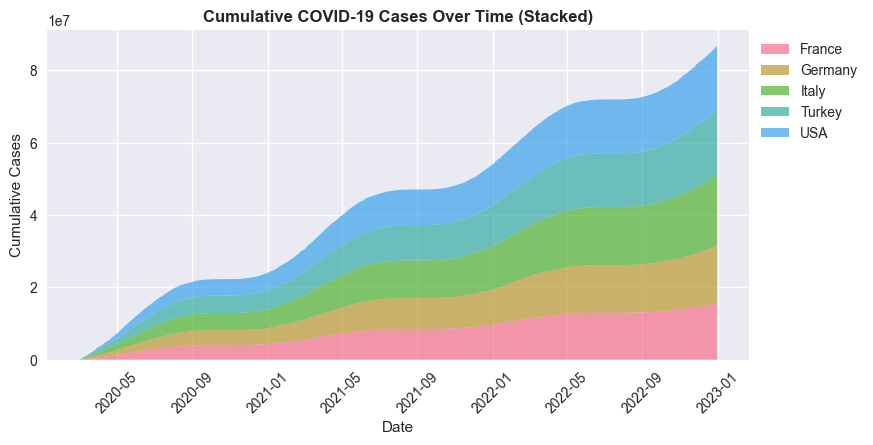

In [18]:
# 8. Area Plot - Cumulative Cases Over Time
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 4)
pivot_data = covid_df[covid_df['country'].isin(top_countries[:5])].pivot_table(
    index='date', columns='country', values='cumulative_cases', fill_value=0)

plt.stackplot(pivot_data.index, *[pivot_data[col] for col in pivot_data.columns], 
              labels=pivot_data.columns, alpha=0.7)
plt.title('Cumulative COVID-19 Cases Over Time (Stacked)', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

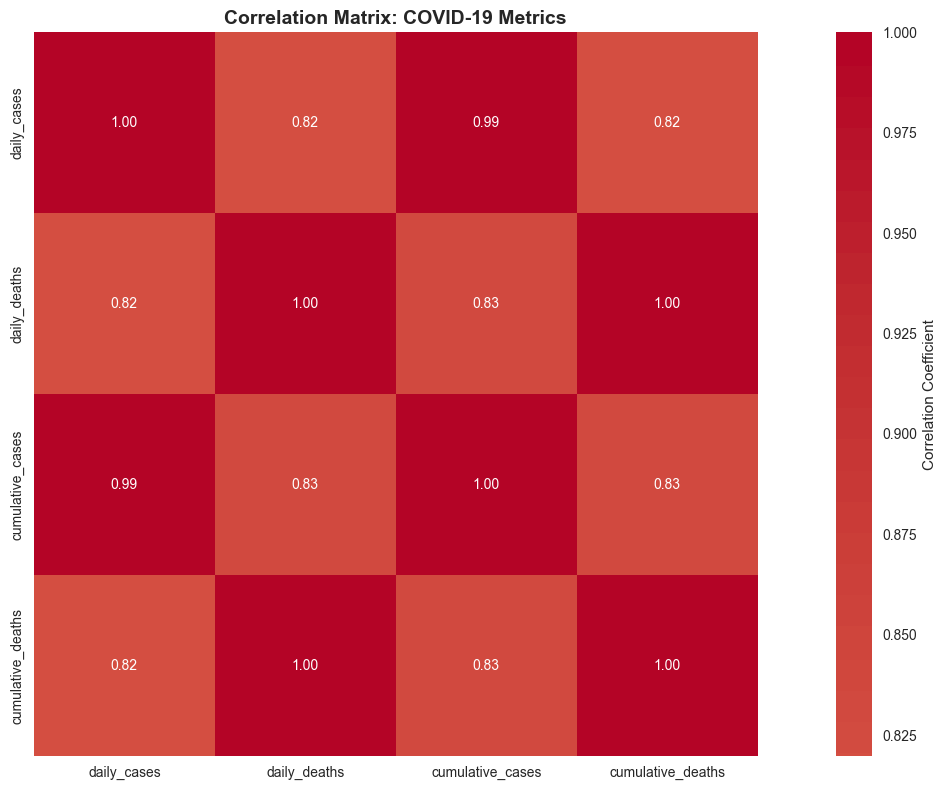

In [19]:
# 9. Correlation Heatmap
plt.figure(figsize=(16,8))
correlation_data = covid_df.groupby('country')[['daily_cases', 'daily_deaths', 
                                               'cumulative_cases', 'cumulative_deaths']].max()
correlation_matrix = correlation_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix: COVID-19 Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

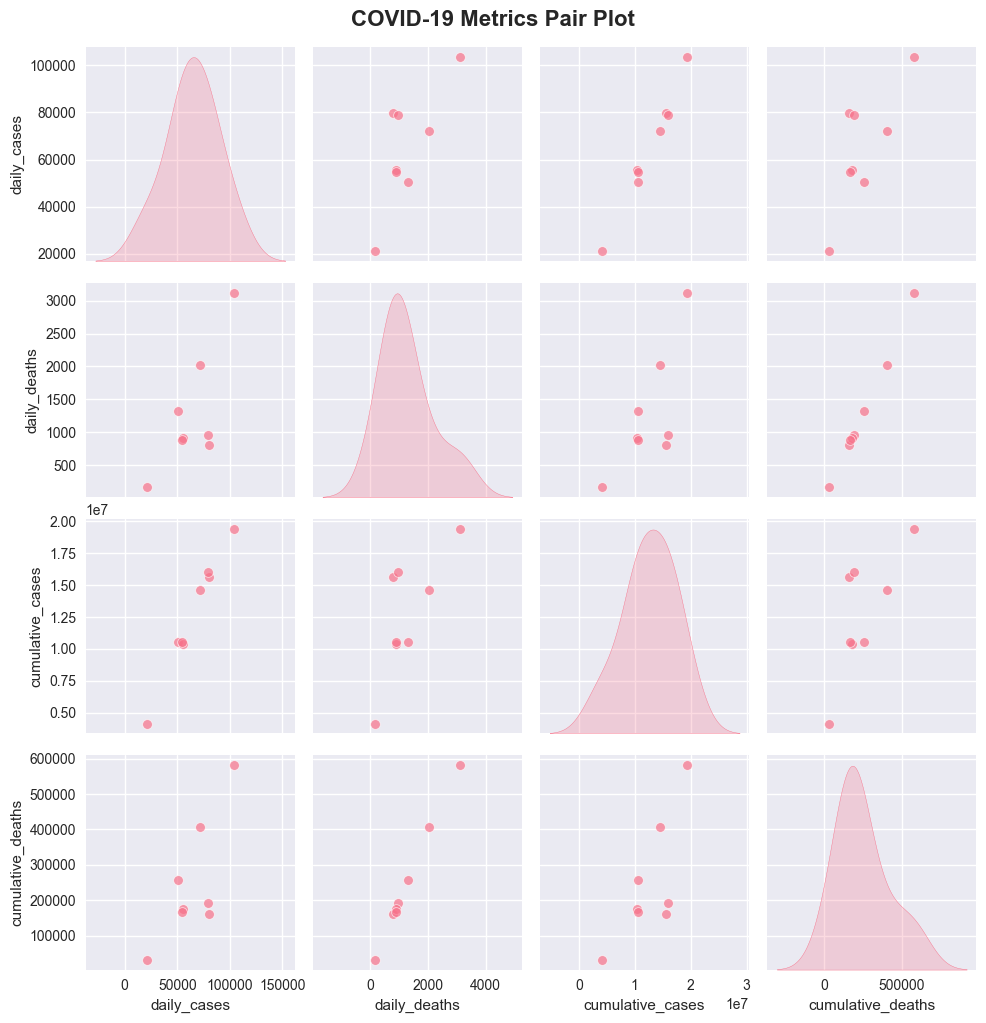

COVID-19 Data Visualization Complete!
Dataset shape: (14504, 7)
Date range: 2020-03-01 00:00:00 to 2022-12-31 00:00:00
Countries included: 14


In [20]:
# 10. Pair Plot for exploring relationships
plt.figure(figsize=(16,8))
sample_data = covid_df.groupby('country')[['daily_cases', 'daily_deaths', 
                                          'cumulative_cases', 'cumulative_deaths']].max().reset_index()
sample_data = sample_data.head(8)  # Top 8 countries for clarity

g = sns.pairplot(sample_data[['daily_cases', 'daily_deaths', 'cumulative_cases', 'cumulative_deaths']], 
                 diag_kind='kde', plot_kws={'alpha': 0.7})
g.fig.suptitle('COVID-19 Metrics Pair Plot', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("COVID-19 Data Visualization Complete!")
print(f"Dataset shape: {covid_df.shape}")
print(f"Date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Countries included: {covid_df['country'].nunique()}")